# Simulated recordings overview (figure 1)

This notebook reproduces Figure 1 of the manuscript: **"How do spike collisions affect spike sorting performance?"**

To run this notebook, you first need to run the `generate_recordings.ipynb` notebook.

In [1]:
import shutil
import sys
from pathlib import Path

import numpy as np
import scipy.spatial

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import MEArec as mr
import spikeinterface.full as si


my_cmap = plt.get_cmap('winter')
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=my_cmap)

In [ ]:
sys.path.append("../utils")

from generation_utils import generation_params
from study_utils import generate_study

In [ ]:
recordings_folder = Path('../data/recordings/'')

In [2]:
# define some parameters

nb_traces = 10 # for panel I
window_ms = 20 #for CC plots
bin_ms = 0.2 # for CC plots
n_cell = 20 #
lag_time = generation_params['lag_time']*1000
corr_level = 0 # to select the appropriate recording if several (run generation first)
rate_level = 5 # to select the appropriate recording if several (run generation first)


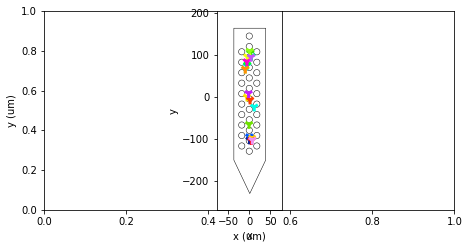

In [8]:
# We use the plotting.py script to ease the creation of figures with several panels. 
figA, axA = plt.subplots()

# We load the file
rec_file = recordings_folder / f'rec0_20cells_5noise_{corr_level}corr_{rate_level}rate_Neuronexus-32.h5'

mearec_object = mr.load_recordings(rec_file)
rec = si.MEArecRecordingExtractor(rec_file)
sorting_gt = si.MEArecSortingExtractor(rec_file)

waveforms_path = Path('.') / 'tmp'
waveforms_path.mkdir(exist_ok=True)

waveforms = si.extract_waveforms(rec, sorting_gt, waveforms_path, ms_before=3, ms_after=3)

original_templates = waveforms.get_all_templates()
snrs = np.array([i for i in si.compute_snrs(waveforms).values()])
rates = np.array([i for i in si.compute_firing_rate(waveforms).values()])


## Plotting the probe layout and the cell positions
si.plot_unit_localization(waveforms, ax=axA)
axA.set_ylabel('y (um)')
axA.set_xlabel('x (um)')

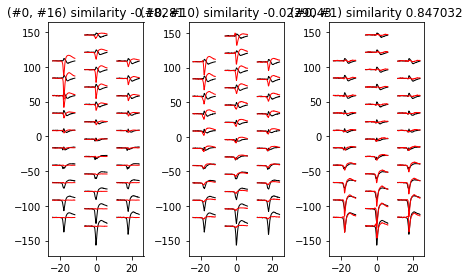

In [9]:
figB, axB = plt.subplots(ncols=3, figsize=(12, 7))

colors = {'#0' : 'k', '#16' : 'r'}

similarities = si.compute_template_similarity(waveforms)

## Plotting example of pair with selected similarity
si.plot_unit_templates(waveforms, plot_templates=True, axes=[axB[0]], unit_ids=['#0'], unit_colors=colors)
si.plot_unit_templates(waveforms, plot_templates=True, axes=[axB[0]], unit_ids=['#16'], unit_colors=colors)
axB[0].set_title('(#0, #16) similarity %02g' %similarities[0, 16])   

colors = {'#0' : 'k', '#10' : 'r'}
si.plot_unit_templates(waveforms, plot_templates=True, axes=[axB[1]], unit_ids=['#0'], unit_colors=colors)
si.plot_unit_templates(waveforms, plot_templates=True, axes=[axB[1]], unit_ids=['#10'], unit_colors=colors)    
axB[1].set_title('(#0, #10) similarity %02g' %similarities[0, 10])

colors = {'#0' : 'k', '#1' : 'r'}
si.plot_unit_templates(waveforms, plot_templates=True, axes=[axB[2]], unit_ids=['#0'], unit_colors=colors)
si.plot_unit_templates(waveforms, plot_templates=True, axes=[axB[2]], unit_ids=['#1'], unit_colors=colors)    
axB[2].set_title('(#0, #1) similarity %02g' %similarities[0, 1])
figB.tight_layout()

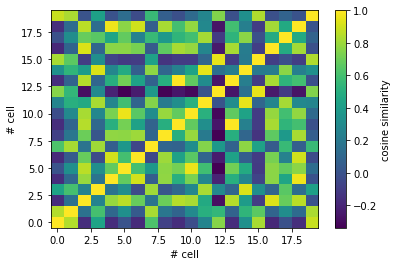

In [11]:
figC, axC = pltsubplotsfigure()

## Plotting the similarity matrix
im = axC.imshow(similarities, cmap='viridis',
                aspect='auto',
                origin='lower',
                interpolation='none',
                extent=(-0.5, n_cell-1+0.5, -0.5, n_cell-1+0.5))
axC.set_xlabel('# cell')
axC.set_ylabel('# cell')
plt.colorbar(im, ax=axC, label='cosine similarity')


Text(0, 0.5, 'probability')

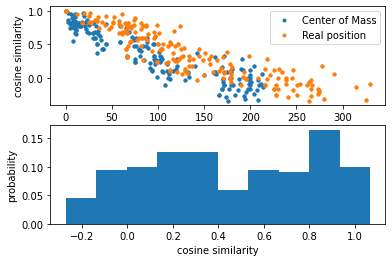

In [12]:
figDE, axDE = plt.subplots(nrows=2)

centers = np.array([v for v in si.compute_unit_centers_of_mass(waveforms).values()])
real_centers = mearec_object.template_locations[:]

distances = scipy.spatial.distance_matrix(centers, centers)
real_distances =  scipy.spatial.distance_matrix(real_centers, real_centers)

# Plotting the distribution of similarities as function of distance (either real or estimated)
axDE[0].plot(distances.flatten(), similarities.flatten(), '.', label='Center of Mass')
axDE[0].plot(real_distances.flatten(), similarities.flatten(), '.', label='Real position')
axDE[0].legend()
axDE[0].set_xlabel('distances (um)')
axDE[0].set_ylabel('cosine similarity')

x, y = np.histogram(similarities.flatten(), 10)
axD[1].bar(y[1:], x/float(x.sum()), width=y[1]-y[0])
axD[1].set_xlabel('cosine similarity')
axD[1].set_ylabel('probability')


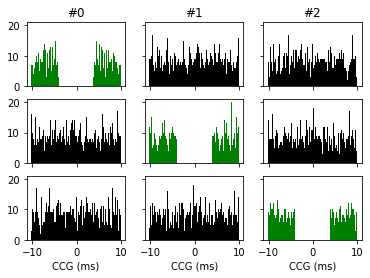

In [14]:
## For the CC, you should uncomment the following line, but the figure was assembled
w = si.plot_crosscorrelograms(sorting_gt, ['#%s' %i for i in range(0,3)], 
                              bin_ms=bin_ms, window_ms=window_ms, symmetrize=True)
figF = w.figure

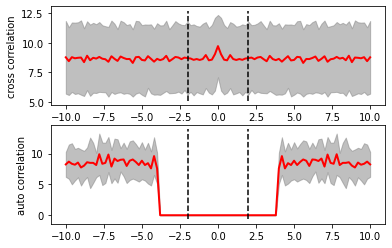

In [16]:
figGH, axGH = plt.subplots(nrows=2)

ccs, lags = si.compute_correlograms(sorting_gt, bin_ms=bin_ms, window_ms=window_ms, symmetrize=True)
ccs = ccs.reshape(n_cell**2, ccs.shape[2])
mask = np.ones(n_cell**2).astype(np.bool)
mask[np.arange(0, n_cell**2, n_cell) + np.arange(n_cell)] = False
mean_cc = np.mean(ccs[mask], 0)
std_cc = np.std(ccs[mask], 0)

## Plotting the average CC
xaxis = (lags[:-1] - lags[:-1].mean())
axGH[0].plot(xaxis, mean_cc, lw=2, c='r')
axGH[0].fill_between(xaxis, mean_cc-std_cc,mean_cc+std_cc, color='0.5', alpha=0.5)
axGH[0].set_xlabel('time (ms)')
axGH[0].set_ylabel('cross correlation')
ymin, ymax = axGH[0].get_ylim()
axGH[0].plot([-lag_time,-lag_time],[ymin,ymax],'k--')
axGH[0].plot([lag_time,lag_time],[ymin,ymax],'k--')

mask = np.zeros(n_cell**2).astype(np.bool)
mask[np.arange(0, n_cell**2, n_cell) + np.arange(n_cell)] = True
mean_cc = np.mean(ccs[mask], 0)
std_cc = np.std(ccs[mask], 0)

xaxis = (lags[:-1] - lags[:-1].mean())
axGH[1].plot(xaxis, mean_cc, lw=2, c='r')
axGH[1].fill_between(xaxis, mean_cc-std_cc,mean_cc+std_cc, color='0.5', alpha=0.5)
axGH[1].set_ylabel('auto correlation')
ymin, ymax = axGH[1].get_ylim()
axGH[1].plot([-lag_time,-lag_time],[ymin,ymax],'k--')
axGH[1].plot([lag_time,lag_time],[ymin,ymax],'k--')


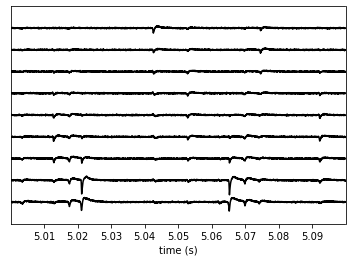

In [18]:
## Plotting timeseries
w = si.plot_timeseries(rec, time_range=(5,5.1), channel_ids=['%s' %i for i in range(1,nb_traces)], color='k')
figI = w.figure